In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import os
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.utils import Sequence
from pathlib import Path
import numpy as np

In [3]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras import backend as K
import sys
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2
import random

In [4]:
train_df = pd.read_csv("sign_data_ver1/train_data.csv")
test_df = pd.read_csv("sign_data_ver1/test_data.csv")


In [5]:
train_df.columns =["img1","img2","similar"]
test_df.columns =["img1","img2","similar"]

In [6]:
train_df

,img1,img2,similar
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
...,...,...,...
23200,031/02_031.png,031/03_031.png,0
23201,031/02_031.png,031/12_031.png,0
23202,031/02_031.png,031/11_031.png,0
23203,031/02_031.png,031/06_031.png,0


In [7]:
train_df["img1"]

0        068/09_068.png
1        068/09_068.png
2        068/09_068.png
3        068/09_068.png
4        068/09_068.png
              ...      
23200    031/02_031.png
23201    031/02_031.png
23202    031/02_031.png
23203    031/02_031.png
23204    031/02_031.png
Name: img1, Length: 23205, dtype: object

In [8]:
print(len(train_df["img1"]))

23205


In [9]:
train_path = "sign_data_ver1/train"
test_path = "sign_data_ver1/test"

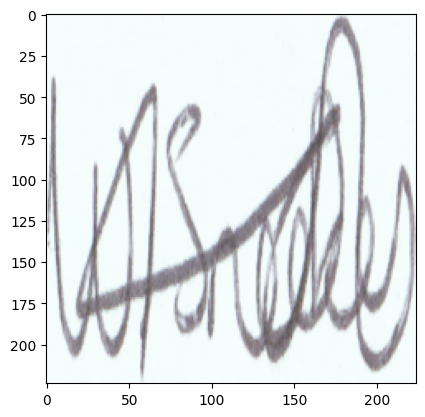

In [10]:
from skimage.io import imread, imshow
from skimage.transform import resize

imgr = imread(os.path.join(train_path,train_df["img1"][0]))
imgr=resize(imgr,(224,224,3))
plt.imshow(imgr)

In [11]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class TrainDataSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set1, x_set2, y_set, batch_size):
        self.x1, self.x2, self.y = x_set1, x_set2, y_set
        self.batch_size = batch_size
        self.train_path = "sign_data_ver1/train"


    def __len__(self):
        return math.ceil(len(self.x1) / self.batch_size)

    def __getitem__(self, idx):
        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_x2 = self.x2[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        X1 = []
        X2 = []
        for file_name1, file_name2 in zip(batch_x1, batch_x2):
                  f1 = resize(imread(os.path.join(self.train_path,file_name1)), (224, 224,3))
                  f2 = resize(imread(os.path.join(self.train_path,file_name2)), (224, 224,3))
                  X1.append(f1)
                  X2.append(f2)
        # print(np.array(X).shape)
        return [np.array(X1), np.array(X2)], np.array(batch_y)


In [12]:

class TestDataSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set1, x_set2, y_set, batch_size):
        self.x1, self.x2, self.y = x_set1, x_set2, y_set
        self.batch_size = batch_size
        self.test_path = "sign_data_ver1/test"

    def __len__(self):
        return math.ceil(len(self.x1) / self.batch_size)

    def __getitem__(self, idx):
        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_x2 = self.x2[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        X1 = []
        X2 = []
        for file_name1, file_name2 in zip(batch_x1, batch_x2):
                  f1 = resize(imread(os.path.join(self.test_path,file_name1)), (224, 224,3))
                  f2 = resize(imread(os.path.join(self.test_path,file_name2)), (224, 224,3))
                  X1.append(f1)
                  X2.append(f2)
        # print(np.array(X).shape)
        return [np.array(X1), np.array(X2)], np.array(batch_y)


In [13]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [14]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [15]:

# def euclidean_distance(vects):
#     x, y = vects
#     return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


# def eucl_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0], 1)


# def contrastive_loss(y_true, y_pred):
#     margin = 1
#     return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


In [16]:
def extractor_model(input_shape):

    vgg_16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#     vgg_16 = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg_16.trainable = False
    x = vgg_16.output
    x = Flatten(name="flatten")(x)
    # x = Dense(512, activation='relu')(x)
    # x = Dropout(0.3)(x)
    output_layer = Dense(128, activation='relu')(x)
#     x = Dense(64, activation='relu')(x)

    # output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=vgg_16.input, outputs=output_layer)

    # model.compile(optimizer=optimizer, 
    #               loss='binary_crossentropy',
    #               metrics=['accuracy'])
    
    return model

In [17]:
def create_model(input_shape):
  print(input_shape)
  base_model = extractor_model(input_shape)
  print(base_model.summary())
  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)
  feat_1 = base_model(input_a)
  feat_2 = base_model(input_b)
  distance = Lambda(euclidean_distance)([feat_1, feat_2])
  outputs = Dense(1, activation="sigmoid")(distance)

  model = Model([input_a, input_b], outputs=outputs)
  return model

In [18]:
input_shape = (224, 224, 3)
optimzer = Adam(learning_rate=0.001)
# n_classes=2
BATCH_SIZE = 32
# n_steps = traingen.samples // BATCH_SIZE
# n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50
train_path = "/content/sign_data/train"
# i_img =cv2.imread(os.path.join(train_path,df["img1"][0]))
# i_img = cv2.resize(i_img,(224,224))
# i_img = i_img[None,:]
# print(i_img.shape)
# First we'll train the model without Fine-tuning
model = create_model(input_shape)
print(model.summary())

print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=optimzer, metrics=["accuracy"])


(224, 224, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128

In [19]:
train_sequence =  TrainDataSequence(train_df['img1'], train_df['img2'], train_df["similar"], batch_size = 32)
test_sequence =  TestDataSequence(test_df['img1'], test_df['img2'], test_df["similar"], batch_size = 32)


history = model.fit(train_sequence,validation_data = test_sequence, epochs = 5, verbose=1)

Epoch 1/5
  2/726 [..............................] - ETA: 3:35:34 - loss: 3.3013 - accuracy: 0.0000e+00

In [ ]:
# model.save("/kaggle/working/saved_model")

In [ ]:
model.save('signature_verification_Siamese.h5')

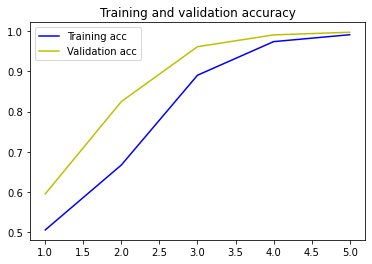

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.savefig("accuracy3.jpg")
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'y', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

plt.show()

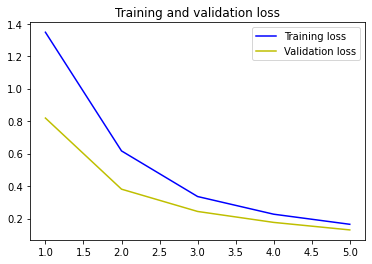

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("loss.jpg")

plt.show()

<!-- <a href="/kaggle/working/my_work.zip"> Download File </a> -->

<!-- <a href="/kaggle/working/signature_verification_Siamese.h5"> Download File </a> -->